# Numerical Project in Python - Cooperative Kernel regression
## Ahmed Yassine Chraa - Emma de Charry - Pauline Zhou



## Part I - Class 1 & 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx

In [2]:
with open('first_database.pkl', 'rb') as f: # Load data
    x,y = pickle.load(f)

In [3]:
# Parameters
n, m, a = 100, 10, 5
sigma2 = 0.25
nu = 1

# Generate data
x_n=x[:n] 
y_n=y[:n]

sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = np.array([x[i] for i in ind])
y_selected = np.array([y[i] for i in ind])

In [4]:
len(x_selected)

10

/Users/paulinezhou/opt/anaconda3/envs/datascience_2025/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


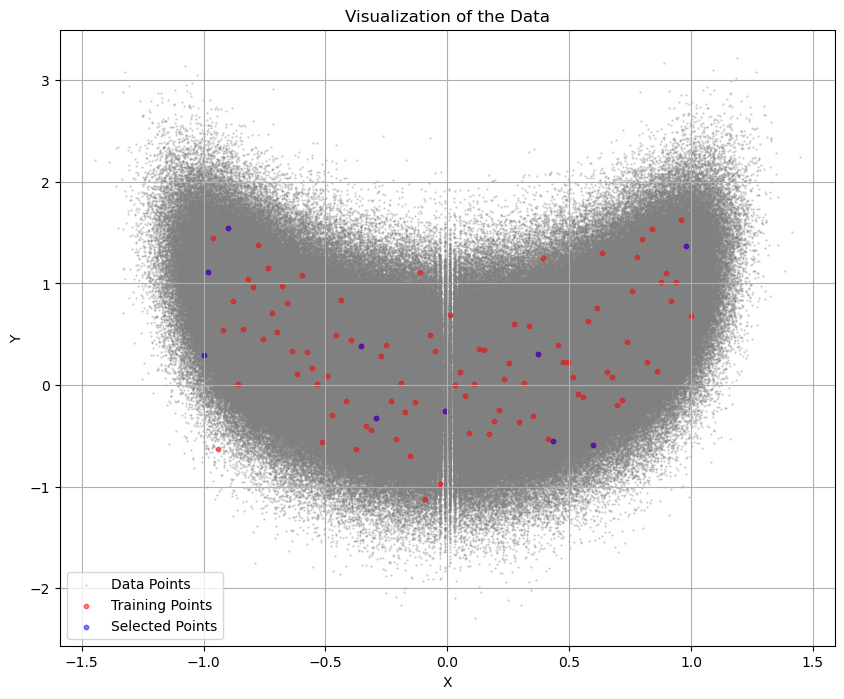

In [5]:
plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='gray',s=0.2, alpha=0.5, label='Data Points')
plt.scatter(x_n, y_n, color='red',s=10, alpha=0.5, label='Training Points')
plt.scatter(x_selected, [y[i] for i in ind], color='blue',s=10, alpha=0.5, label='Selected Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Visualization of the Data')
plt.legend()
plt.grid(True)
plt.show()

#### Useful functions that will be used along the notebook

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
from tqdm import tqdm
import time

def euclidean_kernel(x, y):
    """
    Compute the Euclidean kernel between two vectors.
    """
    return np.exp(-np.linalg.norm(x - y)**2)


def compute_alpha_star(Kmm, Knm, y, sigma2, nu):
    """
    Compute the alpha_star vector.
    """
    m = Kmm.shape[0]
    A = sigma2 * Kmm + Knm.T @ Knm + nu * np.eye(m)
    b = Knm.T @ y
    
    return np.linalg.solve(A, b)

def local_objective_function(alpha, sigma2, K_mm, y_loc, K_im, nu, a):
    """
    Compute the local objective function value.
    """
    t1 = (sigma2 / (2 * a)) * alpha.T @ K_mm @ alpha
    t2 = 0.5 * np.sum((y_loc - K_im @ alpha) ** 2)
    t3 = (nu / (2 * a)) * np.linalg.norm(alpha) ** 2
    
    return t1 + t2 + t3

def nystrom_approx(alpha, X_selected, X):
    """
    Compute the Nystrom approximation.
    """
    K1m = compute_kernel_matrix(X, X_selected)
    return K1m @ alpha

def grad_alpha(sigma2, nu, Y, X, X_selected, alpha, a, m):
    """
    Calcule le gradient local pour chaque agent.
    """
    Kmm = compute_kernel_matrix(X_selected, X_selected)
    grad = np.zeros((a, m))
    
    if alpha.shape[0] != a * m:
        raise ValueError(f"Taille de alpha incorrecte: {alpha.shape}, attendu {(a * m, 1)}")
    
    alpha = alpha.reshape(a, m)  # Assurer une bonne indexation
    
    for i in range(a):
        K_im = compute_kernel_matrix(X[i].reshape(1, -1), X_selected)  # Assurer la bonne forme
        K_im_T = K_im.T
        Y_i = Y[i].reshape(-1, 1) if len(Y[i].shape) == 1 else Y[i]  # Assurer que Y_i a la bonne forme
        grad[i] = (sigma2 / a) * (Kmm @ alpha[i]) + K_im_T @ (K_im @ alpha[i] - Y_i) + (nu / a) * alpha[i]
    
    return grad

def compute_local_gradient(alpha, sigma2, K_mm, y_loc, K_im, nu, a):
    """
    Compute the local gradient.
    """
    grad = (sigma2 / a) * (K_mm @ alpha)
    grad += K_im.T @ (K_im @ alpha - y_loc)
    grad += (nu / a) * alpha
    
    return grad

def compute_kernel_matrix(X, Y):
    """
    Compute the kernel matrix between two sets of vectors.
    """
    rows, cols = X.shape[0], len(Y)
    K = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            K[i, j] = euclidean_kernel(X[i], Y[j])
    
    return K

def compute_local_Hessian(sigma2, Kmm, Kim, nu, a):
    """ Compute local Hessian. """
    return (sigma2 / a) * Kmm + Kim.T @ Kim + (nu / a) * np.eye(Kmm.shape[0])

In [7]:
def plot_me(x,y, alpha, ind, selection=True):

    plt.plot(x,y,'o')

    xo = np.linspace(-1,1,100)
    if selection:
        x2 = [x[i] for i in ind]
    else:
        x2 = np.linspace(-1, 1, 10)


    yo = compute_kernel_matrix(xo, x2) @ alpha
    plt.plot(xo, yo, '-')
    plt.xlabel(r'$x$ feature')
    plt.ylabel(r'$y$ label')
    plt.grid()

    plt.show()


In [8]:
Kmm = compute_kernel_matrix(x_selected, x_selected)
Knm = compute_kernel_matrix(x_n, x_selected)
alpha_star = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
alpha_star

array([ 0.39260692, -0.16009451,  0.45333778, -0.23142558, -0.29826643,
       -0.06018323,  0.24501353, -0.46544667,  0.44329774,  0.94039741])

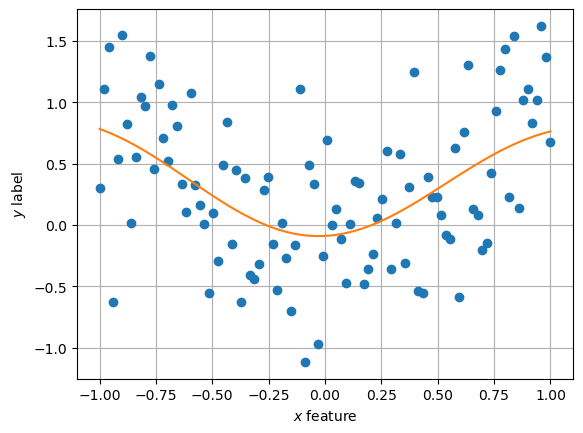

In [9]:
plot_me(x_n, y_n, alpha_star, ind, selection=True)

 ### Decentralized gradient descent

 We are first going to define the DGD function and then apply it.

#### Préparation des données pour DGD
Let each agent have 20 points, and let each agent have diﬀerent points.

In [10]:
def get_agents_from_pickle(pickle_name, a, n, m, plot=False):
    """
    Charge les données depuis un fichier .pkl, sélectionne des points pour l'approximation Nyström
    et répartit les données entre les agents.

    Paramètres :
    - pickle_name : Nom du fichier pickle contenant les données (x, y)
    - a : Nombre d'agents
    - n : Nombre total de points
    - m : Nombre de points sélectionnés pour l'approximation Nyström
    - plot : Affiche les données des agents si True

    Retourne :
    - agent_x : Liste contenant les features de chaque agent (longueur a, chaque élément de taille (20,))
    - agent_y : Liste contenant les labels de chaque agent (longueur a, chaque élément de taille (20,))
    - x_selected : Points sélectionnés pour l'approximation Nyström (taille (m,))
    - y_selected : Labels associés à x_selected (taille (m,))
    - selected_points : Indices des m points sélectionnés
    - selected_points_agents : Indices des points attribués aux agents (matrice de taille (a, n/a))
    - K : Matrice noyau sur les n premiers points (taille (n, n))
    - x_total : Tous les x de la base de données (taille (n,))
    - y_total : Tous les y correspondants (taille (n,))
    """
    
    # Chargement des données depuis le fichier pickle
    with open(pickle_name, 'rb') as f:
        x, y = pickle.load(f)  # x : features, y : labels

    # Sélection aléatoire de m points pour l'approximation Nyström
    selected_points = np.random.choice(n, m, replace=False)
    x_selected = x[selected_points]  # Features des m points sélectionnés
    y_selected = y[selected_points]  # Labels associés

    # Mélange des indices des points pour les répartir aux agents
    selected_points_agents = np.array(range(n))
    np.random.shuffle(selected_points_agents)

    # Répartition des n points entre les a agents (20 points chacun)
    agent_x = []
    agent_y = []
    for j in range(a):
        agent_x.append(x[selected_points_agents[j * 20 : (j + 1) * 20]])
        agent_y.append(y[selected_points_agents[j * 20 : (j + 1) * 20]])

    # Calcul de la matrice noyau complète sur les n points
    K = compute_kernel_matrix(x[0:n], x[0:n])

    # Affichage des données des agents si `plot=True`
    if plot:
        for j in range(a):
            plt.scatter(agent_x[j], agent_y[j], label=f'Agent {j}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

    # Reshape des indices des points attribués aux agents
    selected_points_agents = selected_points_agents.reshape((a, int(n / a)))

    return agent_x, agent_y, x_selected, y_selected, selected_points, selected_points_agents, K, x[:n], y[:n]

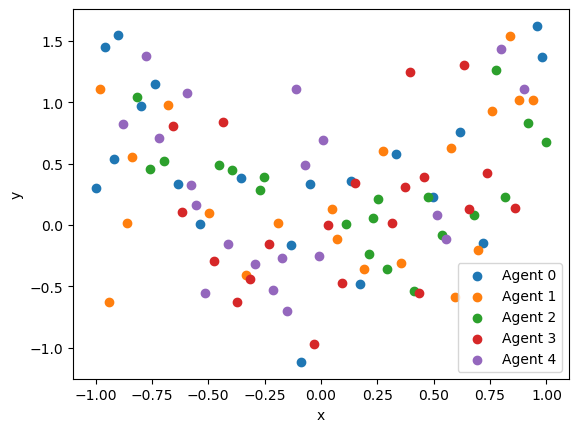

Nombre d'agents : 5
Dimensions de la matrice noyau : (100, 100)


In [11]:
agent_x, agent_y, x_selected, y_selected, selected_points, selected_points_agents, K, x_total, y_total = \
    get_agents_from_pickle("first_database.pkl", a=5, n=100, m=10, plot=True)

print("Nombre d'agents :", len(agent_x))
print("Dimensions de la matrice noyau :", K.shape)

In [43]:
def DGD(x, y, x_selected, a, nu, sigma2, alpha_star, W, lr, n_epochs):
    m = x_selected.shape[0]

    alpha = np.zeros((a * m, 1))        # alpha doit être de dimension au moins m car produit matriciel dans compute_local_gradient Kmm @ alpha

    W_bar = np.kron(W / a, np.eye(m))

    Kmm = compute_kernel_matrix(x_selected, x_selected)

    optimal_gaps = [[] for _ in range(a)]
    alpha_list_agent = []
    alpha_mean_list = []

    for epoch in range(n_epochs):
        # Calcul du gradient local pour chaque agent
        grad = grad_alpha(sigma2, nu, y, x, x_selected, alpha, a, m)
        alpha = W_bar @ alpha - lr * grad.reshape(a * m, 1)
        alpha_list_agent.append(alpha.reshape(a,m))
        alpha_mean_list.append(alpha.reshape(a, m).mean(axis=0))

        for agent_idx in range(a):
            optimal_gaps[agent_idx].append(np.linalg.norm(alpha.reshape(a, m)[agent_idx] - alpha_star))
    
    alpha_optim = alpha.reshape(a, m).mean(axis=0)

    return optimal_gaps, alpha_optim, alpha_list_agent, alpha_mean_list
        

In [44]:

Kmm = compute_kernel_matrix(x_selected, x_selected)
Knm = compute_kernel_matrix(x_n, x_selected)
start = time.time()
alpha_star = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
end = time.time()

print(f'Time to compute alpha star : {end - start}\n')
print(f'Optimal alpha : {alpha_star}\n')

W = np.ones((a,a))
K = compute_kernel_matrix(x_n, x_n)

n_epochs = 100
lr = 0.01

Time to compute alpha star : 0.00018310546875

Optimal alpha : [-0.31416036  1.26202478 -0.73851214 -0.52703289  0.13134308  0.62666766
 -0.38781424  0.52510125 -0.05878766  0.3620298 ]



In [45]:
start = time.time()
opt_gaps_DGD, alpha_optim_DGD, alpha_list_DGD, alpha_mean_list_DGD = DGD(
    x_n, y_n, x_selected, a, nu, sigma2, alpha_star, W, lr, n_epochs=10000)
end = time.time()

print(f'alpha optimal with DGD : {alpha_optim_DGD}')
print(f'Time to compute alpha optimal with DGD : {end - start}')

alpha optimal with DGD : [ 0.1340727   0.33909193  0.05406335 -0.02495016 -0.02968366 -0.02131715
  0.12245038 -0.02356234  0.17162872 -0.02661165]
Time to compute alpha optimal with DGD : 8.328017950057983


We then plot optimality gaps for each agent

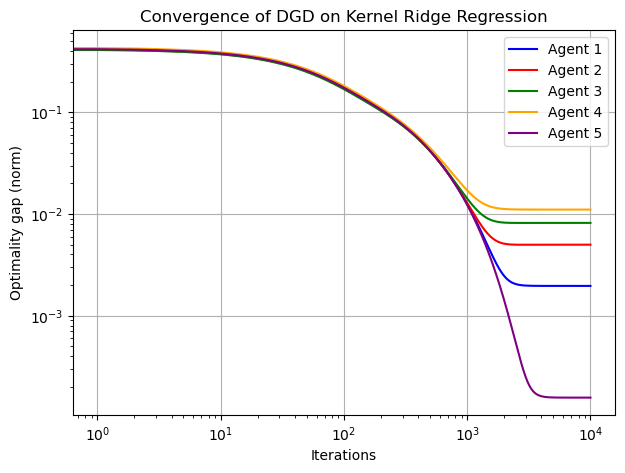

In [46]:
# Data visualization
alpha_list_DGD = np.array(alpha_list_DGD)
alpha_optim_DGD = np.array(alpha_optim_DGD)

# Calcul des écarts d'optimalité pour chaque agent
agent_1 = np.linalg.norm(np.array([alpha_list_DGD[i][0] for i in range(len(alpha_list_DGD))]) - alpha_optim_DGD, axis=1)
agent_2 = np.linalg.norm(np.array([alpha_list_DGD[i][1] for i in range(len(alpha_list_DGD))]) - alpha_optim_DGD, axis=1)
agent_3 = np.linalg.norm(np.array([alpha_list_DGD[i][2] for i in range(len(alpha_list_DGD))]) - alpha_optim_DGD, axis=1)
agent_4 = np.linalg.norm(np.array([alpha_list_DGD[i][3] for i in range(len(alpha_list_DGD))]) - alpha_optim_DGD, axis=1)
agent_5 = np.linalg.norm(np.array([alpha_list_DGD[i][4] for i in range(len(alpha_list_DGD))]) - alpha_optim_DGD, axis=1)

# Tracé des résultat
plt.figure(figsize=(7, 5))
plt.plot(agent_1, label='Agent 1', color='blue')
plt.plot(agent_2, label='Agent 2', color='red')
plt.plot(agent_3, label='Agent 3', color='green')
plt.plot(agent_4, label='Agent 4', color='orange')
plt.plot(agent_5, label='Agent 5', color='purple')
plt.xlabel('Iterations')
plt.ylabel('Optimality gap (norm)')
plt.xscale("log")
plt.yscale("log")
plt.title('Convergence of DGD on Kernel Ridge Regression')
plt.legend()
plt.grid()
plt.show()

### Exploration of Gradient Tracking

In [58]:
def gradient_tracking(x, y, x_selected, a, nu, sigma2, alpha_star, W, lr, n_epochs = 500):
    """
    Implémente l'algorithme de Gradient Tracking (GT).
    
    Paramètres :
    - x, y : Données globales
    - x_selected : Points sélectionnés pour approximation de Nyström
    - a : Nombre d'agents
    - nu : Paramètre de régularisation
    - sigma2 : Hyperparamètre du bruit
    - alpha_star : Solution optimale pour comparaison
    - W : Matrice de consensus
    - lr : Learning rate
    - n_epochs : Nombre d'itérations

    Retourne :
    - optimal_gaps : Liste contenant l'évolution de ||alpha^i - alpha_star|| pour chaque agent.
    - alpha_optim : Dernière valeur de alpha moyenne sur les agents.
    - alpha_list_agent : Liste des valeurs de alphas à chaque itération pour chaque agent.
    - alpha_mean_list : Liste des moyennes de alphas sur les agents à chaque itération.
    """

    m = x_selected.shape[0]

    alpha = np.zeros((a * m, 1))        # Paramètres locaux des agents (a*m, 1)
    g = np.zeros((a * m, 1))            # Terme de suivi du gradient (a*m, 1)

    W_bar = np.kron(W / a, np.eye(m))   # Matrice de consensus

    Kmm = compute_kernel_matrix(x_selected, x_selected)

    optimal_gaps = [[] for _ in range(a)]
    alpha_list_agent = []
    alpha_mean_list = []

    # initialisation du gradient
    grad_old = grad_alpha(sigma2, nu, y, x, x_selected, alpha, a, m).reshape((a * m, 1))  # (a, m)
    g = grad_old.copy()

    for epoch in range(n_epochs):
        # Mise à jour de alpha_i en utilisant g
        alpha = W_bar @ alpha - lr * g

        # Calcul du nouveau gradient
        grad_new = grad_alpha(sigma2, nu, y, x, x_selected, alpha, a, m).reshape((a * m, 1))  # (a, m)

        # Mise à jour de g^i (suivi du gradient)
        g = (W_bar @ g + (grad_new - grad_old))

        grad_old = grad_new
    
        alpha_list_agent.append(alpha.reshape(a, m))
        alpha_mean_list.append(alpha.reshape(a, m).mean(axis=0))

        for agent_idx in range(a):
            optimal_gaps[agent_idx].append(np.linalg.norm(alpha.reshape(a, m)[agent_idx] - alpha_star))

    alpha_optim = alpha.reshape(a, m).mean(axis=0)

    return optimal_gaps, alpha_optim, alpha_list_agent, alpha_mean_list


In [59]:
Kmm = compute_kernel_matrix(x_selected, x_selected)
Knm = compute_kernel_matrix(x_n, x_selected)
start = time.time()
alpha_star = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
end = time.time()

print(f'Time to compute alpha star : {end - start}\n')
print(f'Optimal alpha : {alpha_star}\n')

W = np.ones((a,a))
K = compute_kernel_matrix(x_n, x_n)

n_epochs = 100
lr = 0.01

start = time.time()
opt_gaps_GT, alpha_optim_GT, alpha_list_GT, alpha_mean_list_GT = gradient_tracking(
    x_n, y_n, x_selected, a, nu, sigma2, alpha_star, W, lr, n_epochs=10000)
end = time.time()

print(f'alpha optimal with GT : {alpha_optim_GT}')
print(f'Time to compute alpha optimal with GT : {end - start}')

Time to compute alpha star : 0.0001800060272216797

Optimal alpha : [-0.31416036  1.26202478 -0.73851214 -0.52703289  0.13134308  0.62666766
 -0.38781424  0.52510125 -0.05878766  0.3620298 ]

alpha optimal with GT : [ 0.13401463  0.33903308  0.05401944 -0.02496111 -0.02968132 -0.02131105
  0.12239374 -0.0235567   0.17156716 -0.02660708]
Time to compute alpha optimal with GT : 9.36605978012085


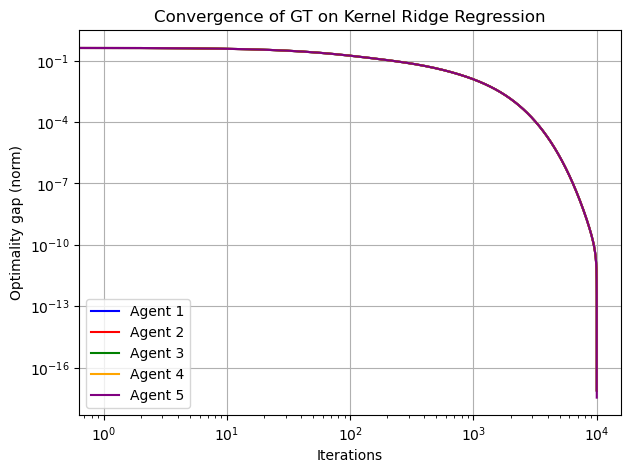

In [60]:
# Data visualization
alpha_list_GT = np.array(alpha_list_GT)
alpha_optim_GT = np.array(alpha_optim_GT)

# Calcul des écarts d'optimalité pour chaque agent
agent_1_GT = np.linalg.norm(np.array([alpha_list_GT[i][0] for i in range(len(alpha_list_GT))]) - alpha_optim_GT, axis=1)
agent_2_GT = np.linalg.norm(np.array([alpha_list_GT[i][1] for i in range(len(alpha_list_GT))]) - alpha_optim_GT, axis=1)
agent_3_GT = np.linalg.norm(np.array([alpha_list_GT[i][2] for i in range(len(alpha_list_GT))]) - alpha_optim_GT, axis=1)
agent_4_GT = np.linalg.norm(np.array([alpha_list_GT[i][3] for i in range(len(alpha_list_GT))]) - alpha_optim_GT, axis=1)
agent_5_GT = np.linalg.norm(np.array([alpha_list_GT[i][4] for i in range(len(alpha_list_GT))]) - alpha_optim_GT, axis=1)

# Tracé des résultats
plt.figure(figsize=(7, 5))
plt.plot(agent_1_GT, label='Agent 1', color='blue')
plt.plot(agent_2_GT, label='Agent 2', color='red')
plt.plot(agent_3_GT, label='Agent 3', color='green')
plt.plot(agent_4_GT, label='Agent 4', color='orange')
plt.plot(agent_5_GT, label='Agent 5', color='purple')
plt.xlabel('Iterations')
plt.ylabel('Optimality gap (norm)')
plt.xscale("log")
plt.yscale("log")
plt.title('Convergence of GT on Kernel Ridge Regression')
plt.legend()
plt.grid()
plt.show()

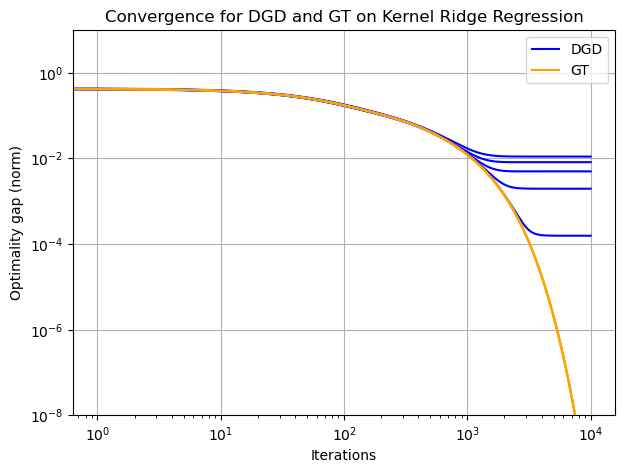

In [63]:
# Tracé des résultats entre DGD et GT
plt.figure(figsize=(7, 5))
plt.plot(agent_1, color='blue')
plt.plot(agent_2, color='blue')
plt.plot(agent_3, color='blue')
plt.plot(agent_4, color='blue')
plt.plot(agent_5, label='DGD', color='blue')

plt.plot(agent_1_GT, color='orange')
plt.plot(agent_2_GT, color='orange')
plt.plot(agent_3_GT, color='orange')
plt.plot(agent_4_GT, label='GT', color='orange')
# plt.plot(agent_5_GT, label='GT', color='orange')

plt.xlabel('Iterations')
plt.ylabel('Optimality gap (norm)')
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-8, 10)
plt.title('Convergence for DGD and GT on Kernel Ridge Regression')
plt.legend()
plt.grid()
plt.show()